# Training and testing a LeNET-5

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os
import glob
import PIL.Image
import cv2

## 3. Read train, validation and test data

In [2]:
def normalize(df):
  normalized_data = (df-df.min())/(df.max()-df.min())
  return normalized_data

In [3]:
train = pd.read_csv("mnist_train.csv")
train = train.astype(float)
test = pd.read_csv("numbers.csv")
test = test.drop(['Unnamed: 0'], axis=1)
test = test[test['label']!='X']
test = test.astype(float)
label_test = test['label']
X = train.iloc[:,1:]/255
Y = train.iloc[:,0]

In [4]:
# Split train and validation sets
train_images, validation_images, train_labels, validation_labels = train_test_split(X, Y, test_size=0.2)
validation_labels = validation_labels.squeeze()

In [5]:
# read our testing dataset
test_images = normalize(test.iloc[:,1:])
test_labels = test['label']

## 4. Preview Data

4.0


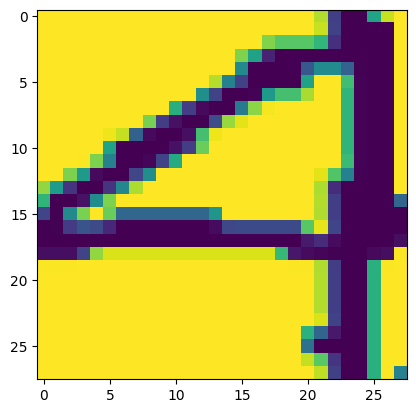

In [6]:
plt.imshow(test_images.iloc[5].values.reshape(28, 28))
print(test_labels.iloc[5])

## 5. Train Model

In [7]:
# LeNet-5 Model architecture
def model(train_x, train_y, valid_x, valid_y, test_x, learning_rate, batch_size, num_epochs):

    # Create placeholder for model input and label.
    # Input shape is (minbatch_size, 28, 28)
    tf.compat.v1.disable_eager_execution()
    X = tf.placeholder(tf.float32, [None, 28, 28], name="X")
    Y = tf.placeholder(tf.int64, [None, ], name="Y")

    def CNN(X):
        # Here we defind the CNN architecture (LeNet-5)

        # Reshape input to 4-D vector
        input_layer = tf.reshape(X, [-1, 28, 28, 1]) # -1 adds minibatch support.

        # Padding the input to make it 32x32. Specification of LeNET
        padded_input = tf.pad(input_layer, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")

        # Convolutional Layer #1
        # Has a default stride of 1
        # Output: 28 * 28 * 6
        conv1 = tf.layers.conv2d(
          inputs=padded_input,
          filters=6, # Number of filters.
          kernel_size=5, # Size of each filter is 5x5.
          padding="valid", # No padding is applied to the input.
          activation=tf.nn.relu)

        # Pooling Layer #1
        # Sampling half the output of previous layer
        # Output: 14 * 14 * 6
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        # Convolutional Layer #2
        # Output: 10 * 10 * 16
        conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=16, # Number of filters
          kernel_size=5, # Size of each filter is 5x5
          padding="valid", # No padding
          activation=tf.nn.relu)

        # Pooling Layer #2
        # Output: 5 * 5 * 16
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        # Reshaping output into a single dimention array for input to fully connected layer
        pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 16])

        # Fully connected layer #1: Has 120 neurons
        dense1 = tf.layers.dense(inputs=pool2_flat, units=120, activation=tf.nn.relu)

        # Fully connected layer #2: Has 84 neurons
        dense2 = tf.layers.dense(inputs=dense1, units=84, activation=tf.nn.relu)

        # Output layer, 10 neurons for each digit
        logits = tf.layers.dense(inputs=dense2, units=10)

        return logits

    # Pass the input thorough our CNN
    logits = CNN(X)
    softmax = tf.nn.softmax(logits)

    # Convert our labels into one-hot-vectors
    labels = tf.one_hot(indices=tf.cast(Y, tf.int32), depth=10)

    # Compute the cross-entropy loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                                     labels=labels))

    # Use adam optimizer to reduce cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cost)

    # For testing and prediction
    predictions = tf.argmax(softmax, axis=1)
    correct_prediction = tf.equal(predictions, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # Initialize all the variables
    init = tf.global_variables_initializer()

    #save array with results
    epoch_cost_list = []
    accuracies_list = []
    # Running the model
    with tf.Session() as sess:

        sess.run(init)

        for epoch in range(num_epochs):
            num_samples = train_x.shape[0]
            num_batches = (num_samples // batch_size) + 1
            epoch_cost = 0.
            i = 0
            while i < num_samples:
                batch_x = train_x.iloc[i:i+batch_size,:].values
                batch_x = batch_x.reshape(batch_x.shape[0], 28, 28)

                batch_y = train_y.iloc[i:i+batch_size].values

                i += batch_size

                # Train on batch and get back cost
                _, c = sess.run([train_op, cost], feed_dict={X:batch_x, Y:batch_y})
                epoch_cost += (c/num_batches)

            # Get accuracy for validation
            valid_accuracy = accuracy.eval(
                feed_dict={X:valid_x.values.reshape(valid_x.shape[0], 28, 28),
                           Y:valid_y.values})

            print ("Epoch {}: Cost: {}".format(epoch+1, epoch_cost))
            print("Validation accuracy: {}".format(valid_accuracy))
            epoch_cost_list.append(epoch_cost)
            accuracies_list.append(valid_accuracy)

        plt.title('Results in Validation Set')
        plt.xlabel('Epoch')
        plt.ylabel('Results')
        plt.plot(epoch_cost_list, label='Cost')
        plt.plot(accuracies_list, label='Accurary')
        plt.legend()
        plt.show()
        return predictions.eval(feed_dict={X:test_x.values.reshape(test_x.shape[0], 28, 28)})

## 6. Test Model

Instructions for updating:
non-resource variables are not supported in the long term


/var/folders/w4/l91llmcx3bz5gf_lbcbb2j4h0000gn/T/ipykernel_16019/1143261583.py:22: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.layers.conv2d(
/var/folders/w4/l91llmcx3bz5gf_lbcbb2j4h0000gn/T/ipykernel_16019/1143261583.py:32: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
/var/folders/w4/l91llmcx3bz5gf_lbcbb2j4h0000gn/T/ipykernel_16019/1143261583.py:36: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.layers.conv2d(
/var/folders/w4/l91llmcx3bz5gf_lbcbb2j4h0000gn/T/ipykernel_16019/1143261583.py:45: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxP

Epoch 1: Cost: 0.17944282426554037
Validation accuracy: 0.9753333330154419
Epoch 2: Cost: 0.08278357841572978
Validation accuracy: 0.981333315372467
Epoch 3: Cost: 0.08084822498510255
Validation accuracy: 0.9794166684150696
Epoch 4: Cost: 0.07008581796379519
Validation accuracy: 0.9781666398048401
Epoch 5: Cost: 0.06943144656106201
Validation accuracy: 0.9822499752044678
Epoch 6: Cost: 0.06896290525447141
Validation accuracy: 0.9678333401679993
Epoch 7: Cost: 0.07241268802672396
Validation accuracy: 0.9790833592414856
Epoch 8: Cost: 0.05245358132463192
Validation accuracy: 0.9791666865348816
Epoch 9: Cost: 0.05902089385100542
Validation accuracy: 0.9796666502952576
Epoch 10: Cost: 0.05315635581170353
Validation accuracy: 0.9797499775886536


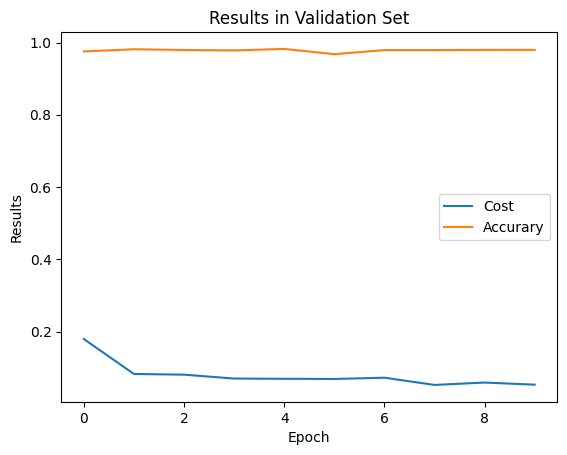

In [8]:
tf.disable_v2_behavior()
prediction  = model(train_images, train_labels, validation_images, validation_labels, test_images, learning_rate=0.01, batch_size=64, num_epochs=10)

In [9]:
confusion = confusion_matrix(np.asarray(label_test), prediction)
confusion

array([[29, 11, 12,  0,  0,  0,  0,  0, 11, 11],
       [13, 20, 21,  2,  1,  0,  1,  3,  4,  2],
       [15, 28, 22,  1,  0,  1,  1,  1,  7,  1],
       [20, 32, 47,  2,  0, 14,  0, 16, 10,  0],
       [ 0,  9, 17, 16,  7,  4,  0,  4,  6, 14],
       [14, 13, 28,  0,  0,  3,  0,  6,  4,  3],
       [24,  7, 12,  3,  0,  8,  1,  1,  5,  2],
       [ 0,  2,  5,  2,  0,  2,  0, 31,  4,  3],
       [ 2,  9, 16,  3,  1,  7,  0,  8,  3,  0],
       [ 3,  1,  1,  3,  0,  0,  0, 28,  3,  7]])

<Axes: >

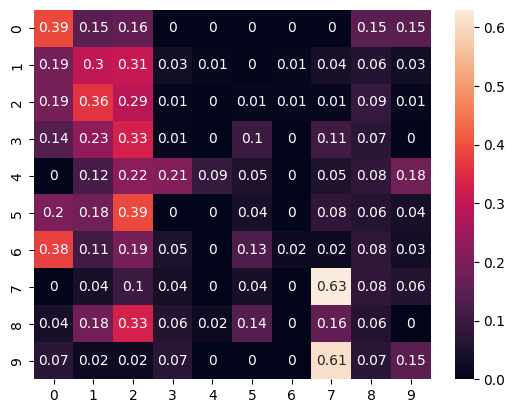

In [10]:
sum_filas = confusion.sum(axis=1)
mat_div = confusion / sum_filas[:, np.newaxis]
mat_div = np.round(mat_div, 2)

labels = [x for x in range(confusion.shape[0])]

sns.heatmap(mat_div, annot=True)